___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2024

___
### Import libraries and sub-libraries.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from skimage.metrics import structural_similarity as ssim
import tifffile 

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [2]:
from fontsetting import font_cmu
plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [3]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cpu


___
### Read training data from `data/train-clean-tif`


In [4]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)

# Create the dataset for the validation images
val_dataset = TIFFDataset('val-clean-tif', transform=transform)

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

train_dataset_size = len(train_dataset)
print('Number of images in the train dataset:', train_dataset_size)

val_dataset_size = len(val_dataset)
print('Number of images in the validation dataset:', val_dataset_size)

Number of images in the train dataset: 52
Number of images in the validation dataset: 16


___
### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [5]:
#DENOISELinear
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [6]:
# # DENOISE1
# class Denoise1OLD(nn.Module):
#     def __init__(self):
#         super(Denoise1, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1),
#             nn.MaxPool2d((2,2),2))
        
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d((2,2),2))

#         self.conv3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d((2,2),2))
        
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d((2,2),2))

#         self.conv5 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d((2,2),2))

#         self.conv55 = nn.Sequential(
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU())
        
        
#         self.relu   = nn.ReLU()
#         self.convT1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
#         self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
#         self.convT2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.conv7 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#         self.convT3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.convT4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
#         self.conv9 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
#         self.convT5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
#         self.conv10 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
       
     

#     def forward(self, x):
#         #print(f"0: {x.shape}")
#         x = self.conv1(x)
#         #print(f"1: {x.shape}")
#         x = self.conv2(x)
#         #print(f"2: {x.shape}")
#         x = self.conv3(x)
#         #print(f"3: {x.shape}")
#         x = self.conv4(x)
#         #print(f"4: {x.shape}")
#         x = self.conv5(x)
#         #print(f"5: {x.shape}")
#         x = self.conv55(x)
#         #print(f"6: {x.shape}")
#         x = self.relu(self.conv6(self.convT1(x)))
#         #print(f"7: {x.shape}")
#         x = self.relu(self.conv7(self.convT2(x)))
#         #print(f"8: {x.shape}")
#         x = self.relu(self.conv8(self.convT3(x)))
#         #print(f"9: {x.shape}")
#         x = self.relu(self.conv9(self.convT4(x)))
#         #print(f"10: {x.shape}")
#         x = self.relu(self.conv10(self.convT5(x)))
#         #x = self.relu(self.convT5(x))
#         #print(f"11: {x.shape}")
#         return x

In [284]:
# DENOISE1
class Denoise1(nn.Module):
    def __init__(self):
        super(Denoise1, self).__init__()
        self.convSkip1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1, stride=4),
            nn.MaxPool2d((2,2),2))
        
        self.convSkip3 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d((2,2),2))

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d((2,2),2))
        
        self.convSkip2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d((2,2),2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2),2))

        self.conv2a = nn.Sequential(
            nn.Conv2d(64, 512, kernel_size=3, padding=1),
            nn.ReLU())

        self.conv2b = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=3, padding=(1,1)),
            nn.ReLU())


        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2),2))
        

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU())
        
        
        self.relu   = nn.ReLU()
        self.convT1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv5  = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.convT2 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.conv6  = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.convT3 = nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2)
        self.conv7  = nn.Conv2d(32, 1, kernel_size=3, padding=1)


    def forward(self, x):
        skip_connection1 = self.convSkip1(x)
        #print(f"S0: {skip_connection1.shape}")

        skip_connection3 = self.convSkip3(x)
        #print(f"S3: {skip_connection3.shape}")

        x = self.conv1(x)
        #print(f"1: {x.shape}")

        skip_connection2 = self.convSkip2(x)
        #print(f"S1: {skip_connection2.shape}")

        x = self.conv2(x)
        #print(f"2: {x.shape}")

        x = self.conv2a(x)
        #print(f"2a: {x.shape}")

        x = self.conv2b(x)
        #print(f"2b: {x.shape}")

        x = self.conv3(x)
        #print(f"3: {x.shape}")

        x = self.conv4(x)
        #print(f"5: {x.shape}")
        
        x = torch.cat((x, skip_connection1), dim=0)
        #print(f"4: {x.shape}")
        
        x = self.relu(self.conv5(self.convT1(x)))
        #print(f"6: {x.shape}")
        
        x = torch.cat((x, skip_connection2), dim=0)
        #print(f"s4: {x.shape}")
        
        
        x = self.relu(self.conv6(self.convT2(x)))
        #print(f"7: {x.shape}")


        x = torch.cat((x, skip_connection3), dim=0)
        #print(f"new4: {x.shape}")


        x = self.relu(self.conv7(self.convT3(x)))
        #print(f"8: {x.shape}")
        
        return x

In [121]:

# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int) -> None:
#         super().__init__()
#         print("Here1")
#         self.conv1 = nn.Conv2d(
#             in_channels=in_channels, out_channels=out_channels, 
#             kernel_size=(3, 3), padding='same', bias=False)
        
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU()
        
#         self.conv2 = nn.Conv2d(
#             in_channels=out_channels, out_channels=out_channels, 
#             kernel_size=(3, 3), padding='same', bias=False)
        
#         self.bn2 = nn.BatchNorm2d(out_channels)
    

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.relu(self.bn2(self.conv2(x)))
         
#         return x
    

# class CustomCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         print("Here2")
#         # Initial convolution layer
#         self.conv = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same', bias=False)
#         self.bn = nn.BatchNorm2d(16)
#         self.relu = nn.ReLU()

#         # First block of residual layers and pooling
#         self.layer1 = nn.Sequential(
#             ResidualBlock(16, 16),
#             ResidualBlock(16, 16),
#             ResidualBlock(16, 16),
#             nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
#         # Second block of residual layers and pooling
#         self.layer2 = nn.Sequential(
#             ResidualBlock(16, 32),
#             ResidualBlock(32, 32),
#             ResidualBlock(32, 32),
#             nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
#         # Third block of residual layers and pooling
#         self.layer3 = nn.Sequential(
#             ResidualBlock(32, 64),
#             ResidualBlock(64, 64),
#             ResidualBlock(64, 64),
#             nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
#         # Fourth block of residual layers and pooling
#         self.layer4 = nn.Sequential(
#             ResidualBlock(64, 128),
#             ResidualBlock(128, 128),
#             ResidualBlock(128, 128),
#             nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
#         # Fifth block of residual layers and pooling
#         self.layer5 = nn.Sequential(
#             ResidualBlock(128, 256),
#             ResidualBlock(256, 256),
#             ResidualBlock(256, 256),
#             nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
        
#         self.convT1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
#         self.conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        
#         self.convT2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

#         self.convT3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
#         self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.convT4 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
#         self.conv4 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

#         self.convT5 = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2)
#         self.conv5 = nn.Conv2d(1, 1, kernel_size=3, padding=1)


#     def forward(self, x):
#         print(f"0: {x.shape}")
#         x = self.relu(self.bn(self.conv(x)))
#         print(f"c1: {x.shape}")
        
#         x = self.layer1(x)
#         print(f"L1: {x.shape}")
#         x = self.layer2(x)
#         print(f"L2: {x.shape}")
#         x = self.layer3(x)
#         print(f"L3: {x.shape}")
#         x = self.layer4(x)
#         print(f"L4: {x.shape}")
#         x = self.layer5(x)
#         print(f"L5: {x.shape}")

#         x = self.relu(self.conv1(self.convT1(x)))
#         print(f"cT1: {x.shape}")

#         x = self.relu(self.conv2(self.convT2(x)))
#         print(f"cT2: {x.shape}")

#         x = self.relu(self.conv3(self.convT3(x)))
#         print(f"cT3: {x.shape}")

#         x = self.relu(self.conv4(self.convT4(x)))
#         print(f"cT4: {x.shape}")

#         x = self.relu(self.conv5(self.convT5(x)))
#         print(f"cT5: {x.shape}")

#         return x

In [9]:
# # DENOISE2
# class Denoise2(nn.Module):
#     def __init__(self):
#         super(Denoise2, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.ReLU())
        
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.ReLU())

#         self.conv3 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.ReLU())
        
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.ReLU())

#         self.conv5 = nn.Sequential(
#             nn.Conv2d(128, 1, kernel_size=(7,7), padding=3, stride=1))


#         self.conv_skip1 = nn.Conv2d(1, 63, kernel_size=(1,1), stride=(1,1))


#         self.conv6 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1))
        

#         self.conv7 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU())
        
#         self.conv8 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU())
        
#         self.conv9 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU())
        
#         self.conv10 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU())
        
#         self.conv11 = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=(3,3), padding=1, stride=1),
#             nn.BatchNorm2d(64))

        
#         self.conv_skip2 = nn.Conv2d(64, 64, kernel_size=(1,1), stride=(1,1))

        
#         self.conv12 = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=(3,3), padding=1, stride=1))
        

#         self.conv_skip3 = nn.Conv2d(64, 64, kernel_size=(1,1), stride=(1,1))



#         self.conv13 = nn.Sequential(
#             nn.Conv2d(128, 1, kernel_size=(7,7), padding=3, stride=1))
        

#     def forward(self, x):
#         #print(f"0: {x.shape}")
#         x_previous1 = self.conv_skip1(x) # skip connection
#         #print(f"1: {x.shape}")
#         x = self.conv1(x)
#         #print(f"2: {x.shape}")
#         x = self.conv2(x)
#         #print(f"3: {x.shape}")
#         x = self.conv3(x)
#         #print(f"4: {x.shape}")
#         x = self.conv4(x)
#         #print(f"5: {x.shape}")
#         x = self.conv5(x)
#         #print(f"6: {x.shape}")
#         x = torch.cat((x, x_previous1), dim=1) # Concatenate the main path with the skip connection
#         #print(f"7: {x.shape}")
#         x = self.conv6(x)
#         #print(f"8: {x.shape}")
#         x_previous2 = self.conv_skip2(x) # skip connection
#         #print(f"9: {x.shape}")
#         x_previous3 = self.conv_skip3(x) # skip connection
#         #print(f"10: {x.shape}")
#         x = self.conv7(x)
#         #print(f"11: {x.shape}")
#         x = self.conv8(x)
#         #print(f"12: {x.shape}")
#         x = self.conv9(x)
#         #print(f"13: {x.shape}")
#         x = self.conv10(x)
#         #print(f"14: {x.shape}")
#         x = self.conv11(x)
#         #print(f"15: {x.shape}")
#         x = torch.cat((x, x_previous2), dim=1)
#         #print(f"16: {x.shape}")
#         x = self.conv12(x)
#         #print(f"17: {x.shape}")
#         x = torch.cat((x, x_previous3), dim=1)
#         #print(f"18: {x.shape}")
#         x = self.conv13(x)
#         #print(f"19: {x.shape}")
#         return x

In [10]:
# class AdvancedCNN(nn.Module):
#     def __init__(self):
#         super(AdvancedCNN, self).__init__()
#         self.relu = nn.ReLU()
        
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=(1,1), stride=(1,1))
#         self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
#         self.bn1 = nn.BatchNorm2d(16)
#         self.dropout1 = nn.Dropout(p=0.1)
                
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=(1,1), stride=(1,1))
#         self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
#         self.bn2 = nn.BatchNorm2d(16)
#         self.dropout2 = nn.Dropout(p=0.1)

#         self.conv_skip = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,1), stride=(1,1))

#         # Adjusted for concatenated output, now twice the depth
#         self.bn3 = nn.BatchNorm1d(32*8*8)  # Adjusted dimension
#         self.dropout3 = nn.Dropout(p=0.25)
        
#         self.dense4 = nn.Linear(32*8*8, 512)  # Adjusted input dimension
#         self.bn4 = nn.BatchNorm1d(512)
#         self.dropout4 = nn.Dropout(p=0.25)
        
#         self.dense5 = nn.Linear(512, 1)
        
#     def forward(self, x):
#         x = self.dropout1(self.bn1(self.pool1(self.relu(self.conv1(x)))))
#         print(f"0:{x.shape}")
#         x_previous = self.conv_skip(x) # skip connection
#         print(f"1:{x.shape}")
#         x = self.conv2(self.bn2(self.relu(self.conv2(x)))) # two convolution layers 
#         print(f"2:{x.shape}")
#         x = torch.cat((x, x_previous), dim=1) # Concatenate the main path with the skip connection
#         print(f"3:{x.shape}")
        
#         x = self.pool2(self.relu(x))
#         print(f"4:{x.shape}")
#         x = self.dropout3(self.bn3(x.view(x.size(0), -1)))
#         print(f"5:{x.shape}")
#         x = self.dropout4(self.bn4(self.relu(self.dense4(x))))
#         print(f"6:{x.shape}")
#         x = self.dense5(x)
#         print(f"7:{x.shape}")
        
#         return x

In [11]:
# # Denoise2ORIGINAL
# class Denoise2ORIGINAL(nn.Module):
#     def __init__(self):
#         super(Denoise2, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.ReLU())
        
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.ReLU())

#         self.conv3 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.ReLU())
        
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.ReLU())

#         self.conv5 = nn.Sequential(
#             nn.Conv2d(128, 1, kernel_size=(7,7), padding=3, stride=1))


#         self.conv_skip1 = nn.Conv2d(1, 1, kernel_size=(1,1), stride=(1,1))


#         self.conv6 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1))
        

#         self.conv7 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU())
        
#         self.conv8 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU())
        
#         self.conv9 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU())
        
#         self.conv10 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU())
        
#         self.conv11 = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=(3,3), padding=1, stride=1),
#             nn.BatchNorm1d(64))

        
#         self.conv_skip2 = nn.Conv2d(64, 64, kernel_size=(1,1), stride=(1,1))

        
#         self.conv12 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1))
        

#         self.conv_skip3 = nn.Conv2d(64, 64, kernel_size=(1,1), stride=(1,1))



#         self.conv13 = nn.Sequential(
#             nn.Conv2d(64, 1, kernel_size=(7,7), padding=3, stride=1))
        

#     def forward(self, x):
#         print(f"0: {x.shape}")
#         x_previous1 = self.conv_skip1(x) # skip connection
#         print(f"1: {x.shape}")
#         x = self.conv1(x)
#         print(f"2: {x.shape}")
#         x = self.conv2(x)
#         print(f"3: {x.shape}")
#         x = self.conv3(x)
#         print(f"4: {x.shape}")
#         x = self.conv4(x)
#         print(f"5: {x.shape}")
#         x = self.conv5(x)
#         print(f"6: {x.shape}")
#         x = torch.cat((x, x_previous1), dim=1) # Concatenate the main path with the skip connection
#         print(f"7: {x.shape}")
#         x = self.conv6(x)
#         print(f"8: {x.shape}")
#         x_previous2 = self.conv_skip2(x) # skip connection
#         print(f"9: {x.shape}")
#         x_previous3 = self.conv_skip3(x) # skip connection
#         print(f"10: {x.shape}")
#         x = self.conv7(x)
#         print(f"11: {x.shape}")
#         x = self.conv8(x)
#         print(f"12: {x.shape}")
#         x = self.conv9(x)
#         print(f"13: {x.shape}")
#         x = self.conv10(x)
#         print(f"14: {x.shape}")
#         x = self.conv11(x)
#         print(f"15: {x.shape}")
#         x = torch.cat((x, x_previous2), dim=1)
#         print(f"16: {x.shape}")
#         x = self.conv12(x)
#         print(f"17: {x.shape}")
#         x = torch.cat((x, x_previous3), dim=1)
#         print(f"18: {x.shape}")
#         x = self.conv13(x)
#         print(f"19: {x.shape}")
#         return x

___
### Define NMSE and SSIM Function

In [12]:
def calculateNMSE(true_img, noisy_img):
    mse = torch.sqrt(torch.sum((true_img - noisy_img) ** 2))    
    nmse = mse / torch.sqrt(torch.sum(true_img ** 2))
    return 20*np.log10(nmse.detach().item())

def calculateSSIM(true_img, noisy_img):
    true_img = np.abs(true_img.detach()).squeeze().numpy()
    noisy_img = np.abs(noisy_img.detach()).squeeze().numpy()
    img_range = np.max(true_img) - np.min(true_img)

    return ssim(true_img, noisy_img, data_range=img_range)

___
### Create a function to execute training. Note, we will call this function later.

In [13]:
def train_model(model, opt, criterion, train_loader, val_loader, num_epoch, noise_std):
    avg_train_losses = []
    avg_nmse_losses = []
    val_nmse_per_epoch = []  # List to store validation NMSE per epoch

    avg_train_ssim_losses = [] 
    val_ssim_per_epoch = [] 

    for epoch in range(num_epoch):
        model.train()
        total_train_loss = 0
        total_nmse_loss = 0

        total_ssim_loss = 0
        avg_batch_train_nmse_loss = 0
        avg_batch_train_ssim_loss = 0

        for i, y_tr_batch in enumerate(train_loader):
            # Train with noisy data
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = y_tr_batch + noise
            
            # rand_speckle = np.random.uniform(0.01, 0.05)
            # x_tr_batch = add_mixed_noise(y_tr_batch, 0.1, rand_speckle)
 
           
            # Test teach base 
            num_batch = y_tr_batch.shape[0]
            for j in range(num_batch):

                opt.zero_grad()
                y_hat_tr_batch_j = model(x_tr_batch[j]) # run the j-th image in the batch through the model

                loss = criterion(y_hat_tr_batch_j, y_tr_batch[j]) # calculates loss for j-th image in batch
                loss.backward()
                opt.step()
                # print(y_tr_batch.shape)
                total_train_loss += loss.item() # sum the loss

                # Aggregate NMSE and SSIM
                total_nmse_loss += calculateNMSE(y_tr_batch[j], y_hat_tr_batch_j)
                total_ssim_loss += calculateSSIM(y_tr_batch[j], y_hat_tr_batch_j)

            # Calculate average across samples in batch training NMSE and SSIM loss
            avg_batch_train_nmse_loss = total_nmse_loss / num_batch
            avg_batch_train_ssim_loss = total_ssim_loss / num_batch

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, '
                      f'MSE: {loss.item():.6f}, '
                      f'NMSE: {avg_batch_train_nmse_loss:.6f}')


        # Calculate average MSE, NMSE, and SSIM for everything across entire training set
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_losses.append(avg_train_loss)

        avg_nmse_loss = avg_batch_train_nmse_loss / len(train_loader)
        avg_nmse_losses.append(avg_nmse_loss)

        avg_train_ssim_loss = avg_batch_train_ssim_loss / len(train_loader)
        avg_train_ssim_losses.append(avg_train_ssim_loss)

        # Calculate validation NMSE per epoch
        val_epoch_nmse = 0
        val_epoch_ssim = 0
        avg_batch_val_nmse = 0
        avg_batch_val_ssim = 0


        for y_val_batch in val_loader:

            # Add noise to validation batch
            noise_val = torch.randn_like(y_val_batch) * noise_std
            x_val_batch = y_val_batch.detach() + noise_val

            num_batch = y_val_batch.shape[0]
            for j in range(num_batch):
                y_hat_val_batch_j = model(x_val_batch[j])
                val_epoch_nmse += calculateNMSE(y_val_batch[j], y_hat_val_batch_j)
                val_epoch_ssim += calculateSSIM(y_val_batch[j], y_hat_val_batch_j)
            
            avg_batch_val_nmse = val_epoch_nmse / num_batch
            avg_batch_val_ssim = val_epoch_ssim / num_batch
                
        val_nmse_per_epoch.append(avg_batch_val_nmse / len(val_loader))
        val_ssim_per_epoch.append(avg_batch_val_ssim / len(val_loader))

    # Plotting (combine training and validation NMSE on same plot)
    fig, ax = plt.subplots(2,1,figsize=(7, 6))
    epochs = range(1, num_epoch + 1)  # X-axis for training NMSE

    ax[0].plot(epochs, avg_nmse_losses, label='Training')
    ax[0].plot(epochs, val_nmse_per_epoch, label='Validation')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('NMSE Loss')
    # No need for log scale here, adjust based on your needs
    ax[0].set_title('Training and Validation NMSE')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(epochs, avg_train_ssim_losses, label='Training')
    ax[1].plot(epochs, val_ssim_per_epoch, label='Validation')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('SSIM')
    # No need for log scale here, adjust based on your needs
    ax[1].set_title('Training and Validation SSIM')
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()


___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Epoch 1, Iteration 10, MSE: 0.002169, NMSE: -103.296045
Epoch 1, Iteration 20, MSE: 0.002141, NMSE: -257.676870
Epoch 2, Iteration 10, MSE: 0.001659, NMSE: -160.201099
Epoch 2, Iteration 20, MSE: 0.001883, NMSE: -321.354054
Epoch 3, Iteration 10, MSE: 0.001519, NMSE: -160.963335
Epoch 3, Iteration 20, MSE: 0.001605, NMSE: -325.258226
Epoch 4, Iteration 10, MSE: 0.001473, NMSE: -163.148176
Epoch 4, Iteration 20, MSE: 0.001005, NMSE: -324.775151
Epoch 5, Iteration 10, MSE: 0.001494, NMSE: -164.712851
Epoch 5, Iteration 20, MSE: 0.001368, NMSE: -328.154064
Epoch 6, Iteration 10, MSE: 0.001561, NMSE: -162.938867
Epoch 6, Iteration 20, MSE: 0.001427, NMSE: -329.033095
Epoch 7, Iteration 10, MSE: 0.001457, NMSE: -164.305222
Epoch 7, Iteration 20, MSE: 0.001583, NMSE: -329.804685
Epoch 8, Iteration 10, MSE: 0.001364, NMSE: -166.054884
Epoch 8, Iteration 20, MSE: 0.001047, NMSE: -332.806140
Epoch 9, Iteration 10, MSE: 0.001332, NMSE: -166.857689
Epoch 9, Iteration 20, MSE: 0.001327, NMSE: -335

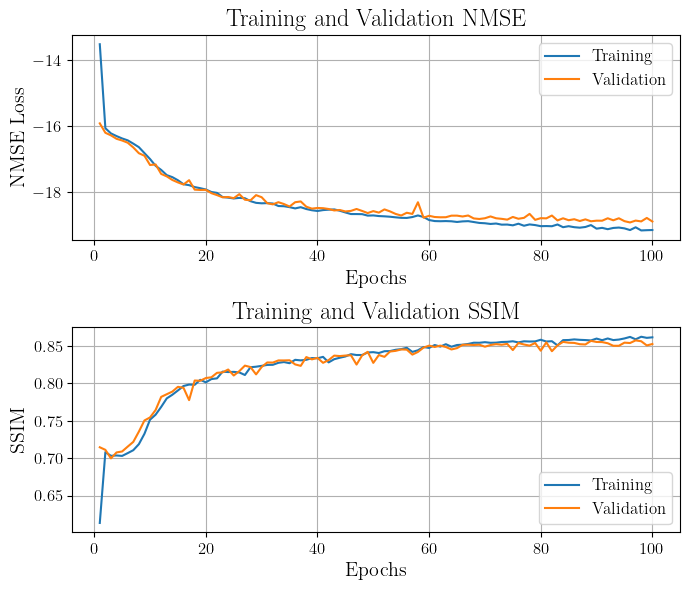

In [285]:
batch_size = 2  # Number of complete images in each batch
lr = 1e-3 # Learning rate
sig = 0.1  # Noise std
num_epoch = 100  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
val_loader = create_loader(val_dataset, 1)
#model = CustomCNN() # Pick a model
model = Denoise1() # Pick a model
#model = DeNoise1()
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
criterion = nn.MSELoss() # Pick a loss function

# Let's train the model
train_model(model, opt, criterion, train_loader, val_loader, num_epoch, noise_std=sig)

In [148]:
#save the model
model = Denoise1() # Pick a model
sig = 0.1
PATH = 'DemaNet2.pt'
torch.save(model.state_dict(), PATH)

___
### Apply it to one of the validation image

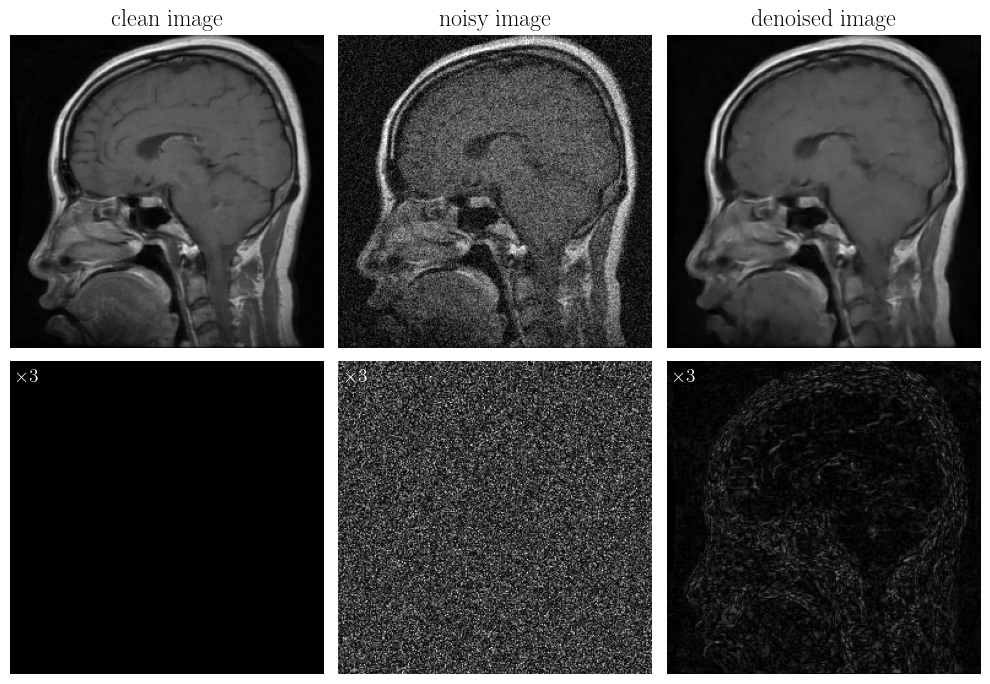

In [286]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()

In [146]:
# Load Testing Data
test_dataset = TIFFDataset('test-clean-tif', transform=transform) # Create the dataset for testing images
len(test_dataset)

16

### Grade Calculation

In [287]:
# Grade Calculation Code

NMSE_te = 0
NMSE_te_sum = 0
SSIM_te = 0
SSIM_te_sum = 0

NMSE_va = 0
NMSE_va_sum = 0
SSIM_va = 0
SSIM_va_sum = 0

sig = 0.1

for val_clean in val_dataset:
    # add random noise
    val_noisy = val_clean + (torch.randn_like(val_clean) * sig)

    # remove noise with model
    val_denoised = model(val_noisy)

    NMSE_va_sum += calculateNMSE(val_clean, val_denoised)
    SSIM_va_sum += calculateSSIM(val_clean, val_denoised)

for test_clean in test_dataset:
    # add random noise
    test_noisy = test_clean + (torch.randn_like(test_clean) * sig)

    # remove noise with model
    test_denoised = model(test_noisy)

    NMSE_te_sum += calculateNMSE(test_clean, test_denoised)
    SSIM_te_sum += calculateSSIM(test_clean, test_denoised)


NMSE_va = NMSE_va_sum / len(val_dataset)
SSIM_va = SSIM_va_sum / len(val_dataset)

NMSE_te = NMSE_te_sum / len(test_dataset)
SSIM_te = SSIM_te_sum / len(test_dataset)

print(f"NMSE_va: {NMSE_va:0.3f}")
print(f"SSIM_va: {SSIM_va:0.3f}")
print()
print(f"NMSE_te: {NMSE_te:0.3f}")
print(f"SSIM_te: {SSIM_te:0.3f}")
print()

NMSE_ref = -20.7 # change to be max from all teams

grade = min((100 - 5*(NMSE_te - NMSE_ref), 100)) 
print(f"Grade: {grade:0.3f}")

NMSE_va: -18.894
SSIM_va: 0.851

NMSE_te: -19.053
SSIM_te: 0.856

Grade: 91.767
